In [12]:
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.graph_objects as go
import pickle
import pandas as pd
import seaborn as sns
from scipy import signal
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from hrvanalysis import get_time_domain_features, get_csi_cvi_features
import librosa
import librosa.display

import util

# 1. Explore data
- Record indicating difficulty in high accuracy: b02 hour 3

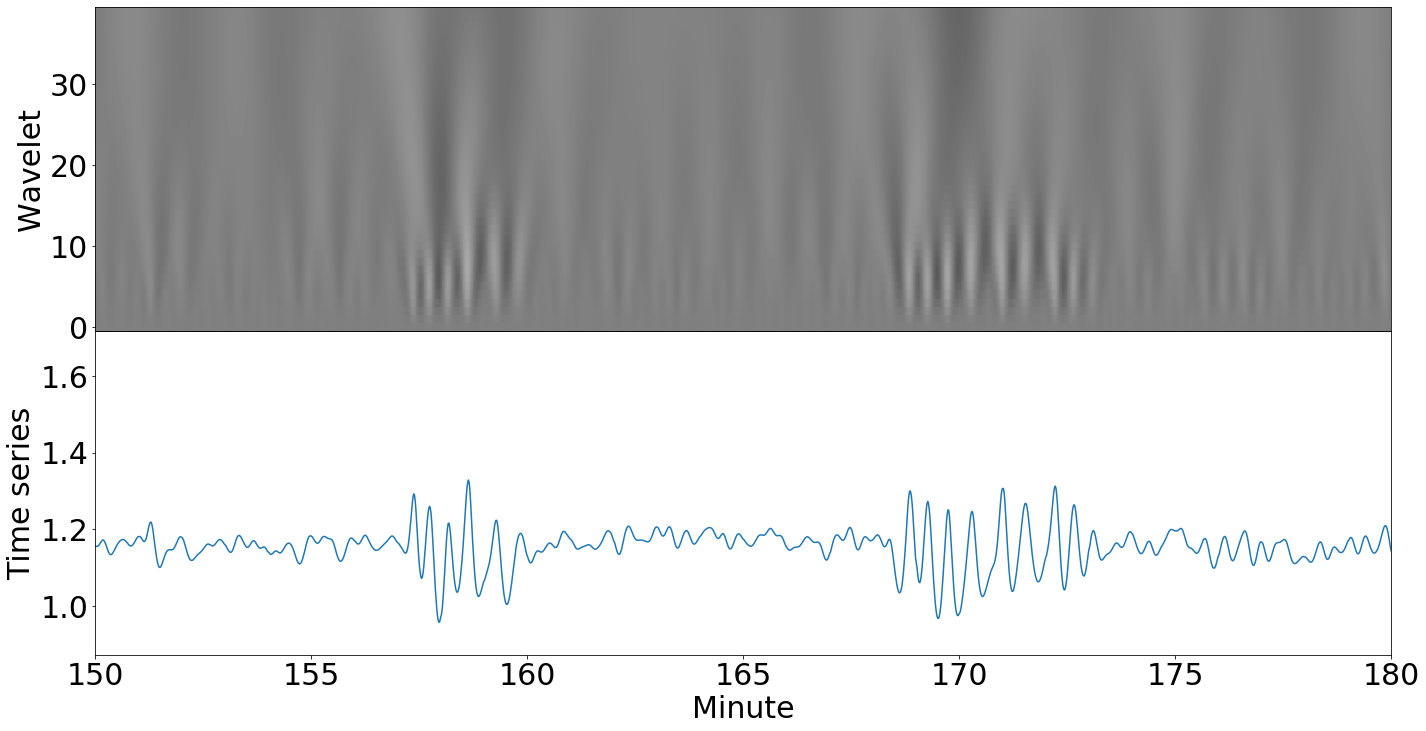

In [6]:
importlib.reload(util)
# matplotlib.rc('font', size=30)

hour = 3
cwt, apn, group = util.get_cwt(
    file='b02', fs_new=1, smooth=True, cwt_width=40, 
    diagPlot=True, xlm=[150, 180]) #[60 * (hour - 1), 60 * hour])

# 2. Determine frequency threshold 

In [66]:
def freq_features(file_names):
    df = pd.DataFrame()
    fs_new = 2.4 # optimized from hyper-parameter tuning
    
    for file in file_names:
        print(file)
        with open(f'../HR_data/{file}.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute
            apn = res['apn']
            group = file[0].upper() 
            
        t_hr, hr_smth = util.smooth_hr(t_hr, hr)
        
        # Resample data for frequency-domain analysis
        t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
        hr_interp = np.interp(t_interp, t_hr, hr_smth)
        
        # Extract features from each segment
        for minute in range(len(apn) - 4):
            fea_dict = {}
            idx_1min = (t_hr > minute + 2) & (t_hr < minute + 3)
            idx_5min = (t_hr > minute) & (t_hr < minute + 5)
            data_1min, data_5min = hr_smth[idx_1min], hr_smth[idx_5min]
            
            hr_interp_1min = hr_interp[(t_interp > minute + 2) & (t_interp < minute + 3)]
            hr_interp_5min = hr_interp[(t_interp > minute) & (t_interp < minute + 5)]
            
            # Discard segment if less than 30 heart beats detected
            if len(data_1min) < 30: 
                continue
                
            # Frequency-domain features
            freq, psd = signal.periodogram(hr_interp_5min, fs=fs_new)
            psd[freq > 0.1] = 0
            
            # Label information
            fea_dict.update({
                'apn': apn[minute + 2],
                'group': group,
                'file': file,
                'psd': psd,
                'freq': freq
            })
            df = df.append(fea_dict, ignore_index=True)
                    
    df['apn'] = df['apn'].astype(int)
    return df

In [67]:
train_df = pd.read_csv('../resources/File_train.csv')
df = freq_features(train_df['file'].values)

c02
b03
a08
a19
a09
a18
a12
a28
c13
a27
b09
c11
a26
c16
c03
b02
a32
c14
a13
a30
a16
a17
a35
a34
a06
a03
a25
a15
a33
b10
c09
a31
c19
c06
a05
b07
a29
a11
c10
a14
a38
c18
a40
a23
a02
a37
c12
a36
b04
b06
c15
b08
a21


In [65]:
# Optimal freq threshold for data_5min
for thres in np.arange(0.005, 0.03, 0.0025):
    for idx in range(len(df)):
        psd = df.loc[idx, 'psd']
        freq = df.loc[idx, 'freq']
        df.loc[idx, 'peak'] = psd.max()
        df.loc[idx, 'f_peak'] = freq[np.argmax(psd)]
        df.loc[idx, 'area_total'] = psd.sum()
        df.loc[idx, 'area_lf'] = psd[freq < thres].sum()
        df.loc[idx, 'area_hf'] = psd[freq > thres].sum(),
        df.loc[idx, 'area_ratio'] = psd[freq > thres].sum() / psd[freq < thres].sum()
        
    feature_col = ['peak', 'f_peak', 'area_total', 'area_lf', 'area_hf', 'area_ratio']
    logreg = LogisticRegression(solver='lbfgs', max_iter=1e6)
    acc_train, acc_val, _ = util.model_evaluation_CV(logreg, df, train_df, feature_col, normalize=True, n=4)
    print(f'Thres={thres}: {acc_train:.3f} for training, {acc_val:.3f} for validation')

Thres=0.005: 0.774 for training, 0.774 for validation
Thres=0.0075: 0.789 for training, 0.786 for validation
Thres=0.009999999999999998: 0.789 for training, 0.786 for validation
Thres=0.012499999999999999: 0.794 for training, 0.792 for validation
Thres=0.015: 0.797 for training, 0.796 for validation
Thres=0.017499999999999998: 0.791 for training, 0.790 for validation
Thres=0.019999999999999997: 0.791 for training, 0.790 for validation
Thres=0.0225: 0.781 for training, 0.778 for validation
Thres=0.024999999999999998: 0.776 for training, 0.772 for validation
Thres=0.027499999999999997: 0.780 for training, 0.776 for validation


# 3. Extract features

In [14]:
def extract_features(file):
    fs_new = 2.4 # optimized from hyper-parameter tuning
    thres = 0.015
    df = pd.DataFrame()

    with open(f'../HR_data/{file}.pkl', 'rb') as f:
        res = pickle.load(f)
        hr = res['hr']
        t_hr = res['t'] # in minute
        apn = res['apn']
        group = file[0].upper() 

    t_hr, hr_smth = util.smooth_hr(t_hr, hr)

    # Resample data for frequency-domain analysis
    t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
    hr_interp = np.interp(t_interp, t_hr, hr_smth)

    # Extract features from each segment
    for minute in range(len(apn) - 4):
        fea_dict = {}
        idx_1min = (t_hr > minute + 2) & (t_hr < minute + 3)
        idx_5min = (t_hr > minute) & (t_hr < minute + 5)
        data_1min, data_5min = hr_smth[idx_1min], hr_smth[idx_5min]

        hr_interp_1min = hr_interp[(t_interp > minute + 2) & (t_interp < minute + 3)]
        hr_interp_5min = hr_interp[(t_interp > minute) & (t_interp < minute + 5)]

        # Discard segment if less than 30 heart beats detected
        if len(data_1min) < 30: 
            continue

        # Time-domain features for data_1min
        md = np.median(data_1min)
        fea_dict.update({
            'md_1min': md,
            'min_r_1min': data_1min.min() - md,
            'max_r_1min': data_1min.max() - md,
            'p25_r_1min': np.percentile(data_1min, 0.25) - md,
            'p75_r_1min': np.percentile(data_1min, 0.75) - md,
            'mean_r_1min': data_1min.mean() - md,
            'std_1min': data_1min.std(),
            'acf1_1min': pd.Series(hr_interp_1min).autocorr(12),
            'acf2_1min': pd.Series(hr_interp_1min).autocorr(24),
        })

        # Time-domain features for data_5min
        md = np.median(data_5min)
        fea_dict.update({
            'md_5min': md,
            'min_r_5min': data_5min.min() - md,
            'max_r_5min': data_5min.max() - md,
            'p25_r_5min': np.percentile(data_5min, 0.25) - md,
            'p75_r_5min': np.percentile(data_5min, 0.75) - md,
            'mean_r_5min': data_5min.mean() - md,
            'std_5min': data_5min.std(),
            'acf1_5min': pd.Series(hr_interp_5min).autocorr(12),
            'acf2_5min': pd.Series(hr_interp_5min).autocorr(24),
        })

        # Heart rate variability for data_1min
        nn_intervals = (np.diff(t_hr[idx_1min]) * 1000 * 60).astype(int) # Unit in ms
        time_domain_features = get_time_domain_features(nn_intervals)
        time_domain_features = {f'{key}_1min': value for key, value in time_domain_features.items()}
        nonlinear_features = get_csi_cvi_features(nn_intervals)
        nonlinear_features = {f'{key}_1min': value for key, value in nonlinear_features.items()}
        fea_dict.update(time_domain_features)
        fea_dict.update(nonlinear_features)

        # Heart rate variability for data_5min
        nn_intervals = (np.diff(t_hr[idx_5min]) * 1000 * 60).astype(int) # Unit in ms
        time_domain_features = get_time_domain_features(nn_intervals)
        time_domain_features = {f'{key}_5min': value for key, value in time_domain_features.items()}
        nonlinear_features = get_csi_cvi_features(nn_intervals)
        nonlinear_features = {f'{key}_5min': value for key, value in nonlinear_features.items()}
        fea_dict.update(time_domain_features)
        fea_dict.update(nonlinear_features)

        # Frequency-domain features
        freqs, psd = signal.periodogram(hr_interp_5min, fs=fs_new)
        psd[freqs > 0.1] = 0
        fea_dict.update({
            'peak': psd.max(),
            'f_peak': freqs[np.argmax(psd)],
            'area_total': psd.sum(),
            'area_lf': psd[freqs < thres].sum(),
            'area_hf': psd[freqs > thres].sum(),
            'area_ratio': psd[freqs > thres].sum() / psd[freqs < thres].sum(),
        })

        # Label information
        fea_dict.update({
            'apn': apn[minute + 2],
            'group': group,
            'file': file,
        })
        df = df.append(fea_dict, ignore_index=True)
                    
    df['apn'] = df['apn'].astype(int)
    return df

In [15]:
file_all = pd.read_csv('../resources/File_all.csv')
for file in file_all['file']:
    print(file)
    df = extract_features(file)
    df.dropna(inplace=True)
    df.to_csv(f'../features/{file}.csv', index=False)

a01
a02
a03
a04
a05
a06
a07
a08
a09
a10
a11
a12
a13
a14
a15
a16
a17


C:\Users\joey3\Anaconda3\envs\apnea-ecg\lib\site-packages\hrvanalysis\extract_features.py:106: RuntimeWarning:

invalid value encountered in sqrt



a18
a19
a20
a21
a22
a23
a24
a25
a26
a27
a28
a29
a30
a31
a32
a33
a34
a35
a36
a37
a38
a39
a40
b01
b02
b03
b04
b05
b06
b07
b08
b09
b10
c01
c02
c03
c04


C:\Users\joey3\Anaconda3\envs\apnea-ecg\lib\site-packages\hrvanalysis\extract_features.py:537: RuntimeWarning:

invalid value encountered in sqrt



c05
c06
c07
c08
c09
c10
c11
c12
c13
c14
c15
c16
c17
c18
c19
c20


# 4. Feature selection

In [2]:
file_train = pd.read_csv('../resources/File_train.csv')
file_train

df = pd.DataFrame()
for file in file_train['file']:
    df = df.append(pd.read_csv(f'../features/{file}.csv'))

## 4.1 Features with high correlation

In [3]:
# Normalize features
df_temp = df.drop(['apn', 'file', 'group'], axis=1)
df_temp = (df_temp - df_temp.mean()) / df_temp.std()

# Calculate correlations
corr = df_temp.corr()
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(np.bool))

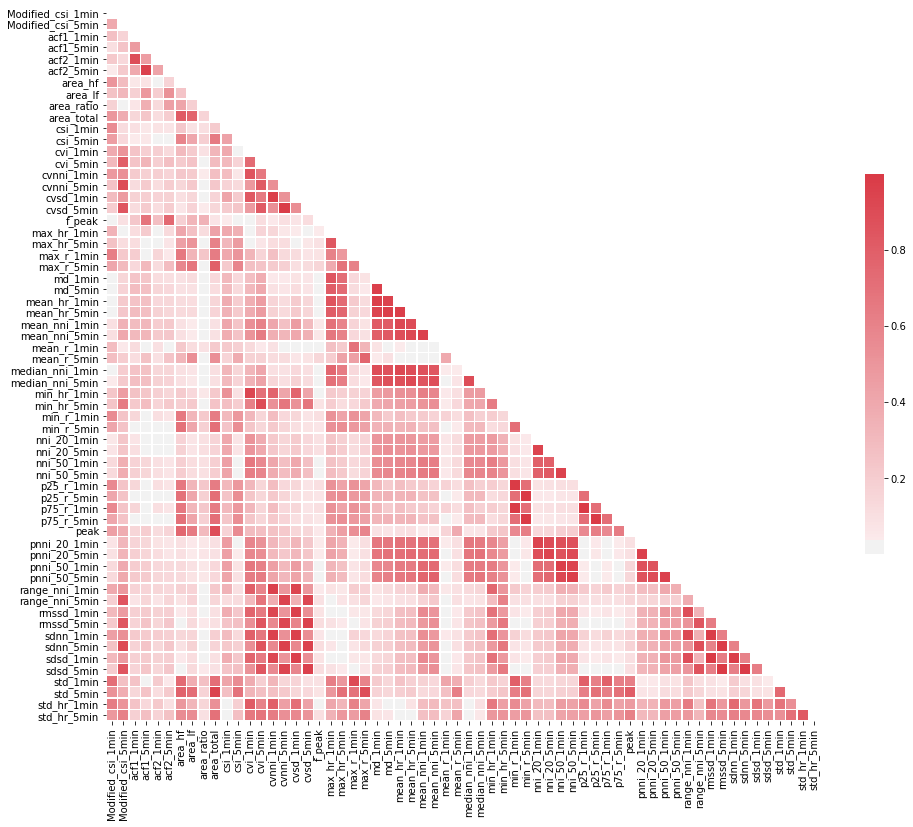

In [10]:
f, ax = plt.subplots(figsize=(16, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr.abs(), cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('../archive/Feature_correlation.png', dpi=300)

In [5]:
to_drop = [column for column in corr.columns if any(corr.abs()[column] > 0.98)]
df = df.drop(to_drop, axis=1)

In [7]:
with open('../features/feature_selection.pkl', 'wb') as f:
    pickle.dump(list(df.drop(['apn', 'file', 'group'], axis=1).columns), f)

## 4.2 Features with low importance

In [8]:
X = df.drop(['apn', 'file', 'group'], axis=1)
X = (X - X.mean()) / X.std()
y = df['apn']

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

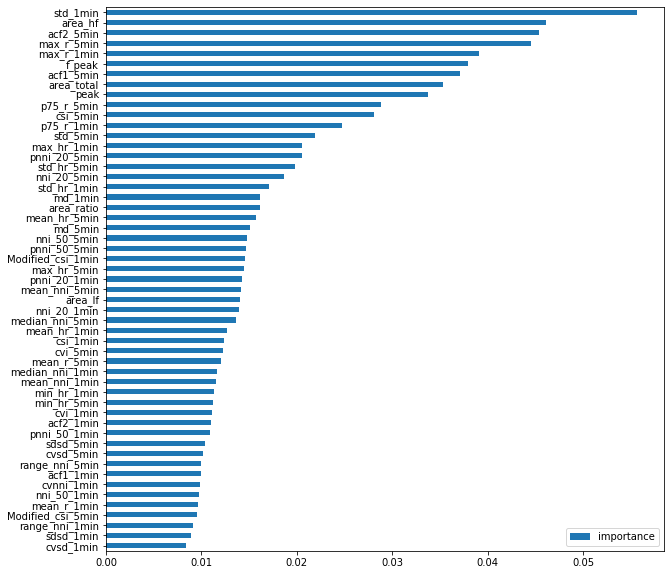

In [11]:
temp = pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance'])
ax = temp.sort_values('importance').plot.barh(figsize=(10,10))
plt.savefig('../archive/Feature_importance.png', dpi=300)

# Other frequency-domain features

In [48]:
file = 'b02'
fs_new = 2.4
b, a = signal.butter(3, 0.1)

with open('features/HR_' + file + '.pkl', 'rb') as f:
    data = pickle.load(f)

with open('data/processed/' + file + '.pkl', 'rb') as f:
    apn = pickle.load(f)['apn']
    group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper()   

# Remove outliers    
idx_valid = (data['hr'] < 2) & (data['hr'] > 0.5)
hr_raw, t_raw = data['hr'][idx_valid], data['t'][idx_valid]

# Smooth data
hr_raw = signal.filtfilt(b, a, hr_raw)

# Resample data for frequency-domain analysis
t = np.arange(t_raw[0], t_raw[-1], 1 / fs_new / 60)
hr = np.interp(t, t_raw, hr_raw)

minute = 0
idx = (t > minute) & (t < minute + 5)

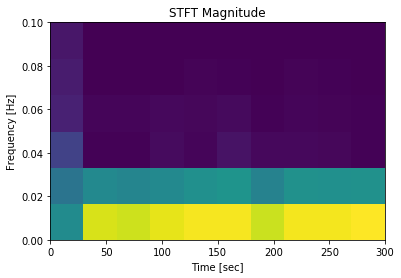

In [49]:
# STFT
f, t_stft, Zxx = signal.stft(
    hr[idx], fs=fs_new, window='hann', 
    nperseg=24*6, noverlap=None, nfft=None, detrend=False, 
    return_onesided=True, boundary='zeros', padded=True)
plt.pcolormesh(t_stft, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0, 0.1])
plt.show()

# spectrogram
f, t_sg, Sxx = signal.spectrogram(
    hr[idx], fs=fs_new,
    window='hann', nperseg=24*6, noverlap=None, 
    nfft=None, detrend=False, return_onesided=True, 
    scaling='density', mode='psd')
plt.pcolormesh(t_sg, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.xlim([0, 300])
plt.ylim([0, 0.1])
plt.show()

# MFCC
mfccs = librosa.feature.mfcc(y=hr, sr=fs_new, n_mfcc=40)
print(mfccs.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
# plt.xlim([0, 5])
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()